/var/folders/bj/cqz9v_7s4pxcpym130bfjj0w0000gr/T/ipykernel_98321/3535712388.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buys['year'] = buys['trandate'].dt.year


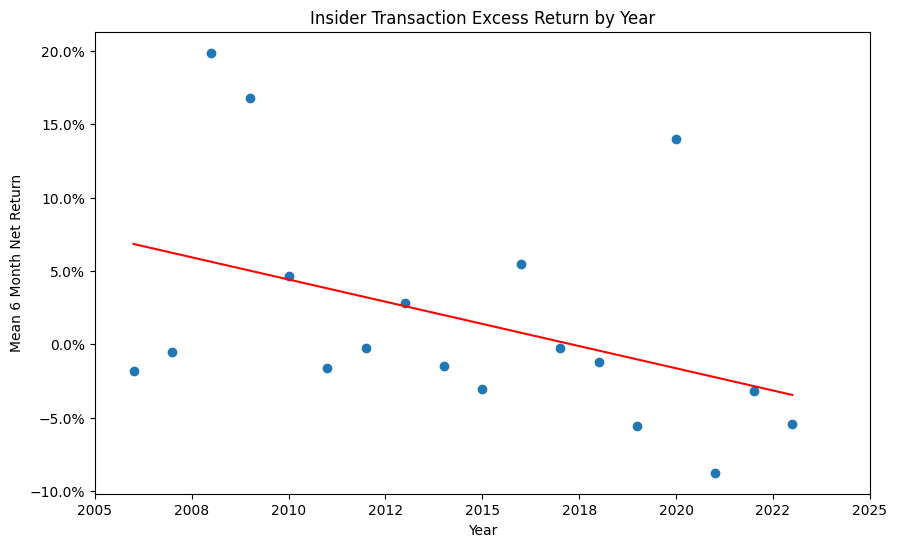

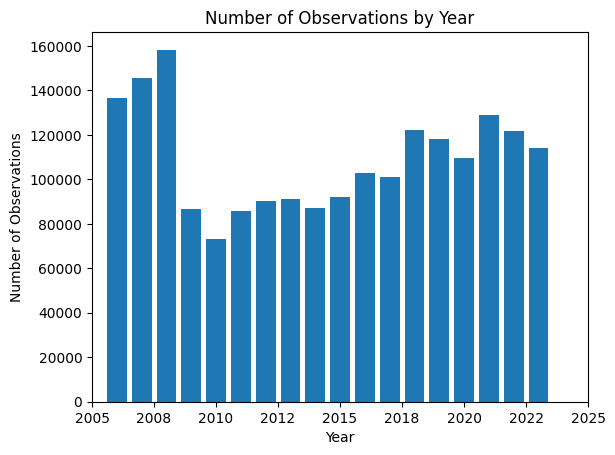

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import lxml

insiders_df = pd.read_pickle("merge_etf_2.pkl")
# insiders_df = pd.read_pickle("CRSP_merged.pkl")

buys = insiders_df[insiders_df['acqdisp'] == 'A']
sells = insiders_df[insiders_df['acqdisp'] == 'D']
buys['year'] = buys['trandate'].dt.year
buys = buys[((buys['year'] >= 2006) & (buys['year'] <= 2023))]
mean_net_ret_by_year = buys.groupby('year')['net_ret'].mean().reset_index()

import numpy as np
x = mean_net_ret_by_year['year'].values
y = mean_net_ret_by_year['net_ret'].values

coefficients = np.polyfit(x, y, deg=1)
poly_eq = np.poly1d(coefficients)
y_fit = poly_eq(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='', label='Data Points')
plt.plot(x, y_fit, color='red', linestyle='-', label='Fitted Line')
plt.title('Insider Transaction Excess Return by Year')
plt.xlabel('Year')
plt.ylabel('Mean 6 Month Net Return')

# Set y-axis labels to percentage
formatter = mticker.PercentFormatter(xmax=1, decimals=1)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlim(2005, 2025)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
plt.grid(False)
plt.savefig('figures/mean_excess_ret_by_year.pdf')
plt.show()

obs_count_by_year = buys['year'].value_counts().sort_index()
plt.bar(obs_count_by_year.index, obs_count_by_year.values)
plt.title('Number of Observations by Year')
plt.xlabel('Year')
plt.xlim(2005, 2025)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))
plt.ylabel('Number of Observations')
plt.grid(False)

In [2]:
mean_net_ret_by_year

,year,net_ret
0,2006,-0.018459
1,2007,-0.005139
2,2008,0.198740
3,2009,0.168106
4,2010,0.046327
5,2011,-0.016132
6,2012,-0.002378
7,2013,0.028180
8,2014,-0.014734
9,2015,-0.030262


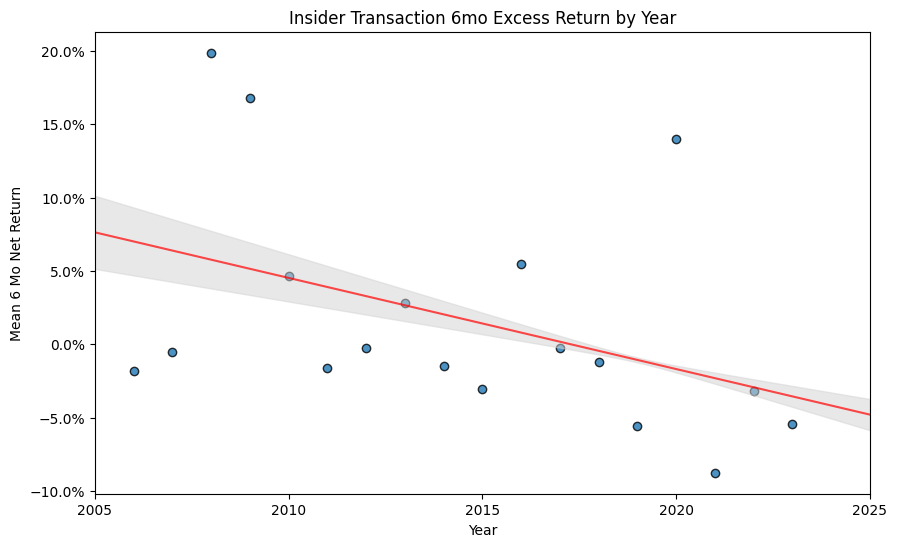

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.ticker as mticker

# Load data
insiders_df = pd.read_pickle("merge_etf_2.pkl")

# Create 'year' column
insiders_df['year'] = insiders_df['trandate'].dt.year

# Filter 'buys' data within specified years
buys = insiders_df[(insiders_df['acqdisp'] == 'A') & (insiders_df['year'] >= 2006) & (insiders_df['year'] <= 2023)]

# Prepare data for regression
x = buys['year'].values
y = buys['net_ret'].values
groups = buys['dcn'].values
X = sm.add_constant(x)  # Add a constant (intercept term)

# Perform the regression with clustered standard errors
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': groups})

# Create a smoother range of x-values for plotting the fitted line and confidence intervals
x_fit = np.linspace(2005, 2025, 200)  # Extended range for the plot
X_fit = sm.add_constant(x_fit)

# Get predictions over this range
predictions = model.get_prediction(X_fit)
y_fit = predictions.predicted_mean
conf_int = predictions.conf_int()

# Calculate means for plotting
mean_net_ret_by_year = buys.groupby('year')['net_ret'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(mean_net_ret_by_year['year'], mean_net_ret_by_year['net_ret'], label='Mean Data Points', alpha=0.8, edgecolors='k')
plt.plot(x_fit, y_fit, color='red', linestyle='-', label='Fitted Line', alpha=0.7)

# Shading the uncertainty
plt.fill_between(x_fit, conf_int[:, 0], conf_int[:, 1], color='lightgrey', alpha=0.5, label='Confidence Interval')

# Set x-axis limits and labels
plt.xlim(2005, 2025)
plt.xticks(np.arange(2005, 2026, 5))
formatter = mticker.PercentFormatter(xmax=1, decimals=1)
plt.gca().yaxis.set_major_formatter(formatter)
plt.xlim(2005, 2025)
plt.grid(False)

# Labels and Title
plt.title('Insider Transaction 6mo Excess Return by Year')
plt.xlabel('Year')
plt.ylabel('Mean 6 Mo Net Return')
plt.savefig('figures/mean_excess_ret_by_year_errors.pdf')
plt.show()


In [4]:
buys['net_ret'].describe()

count    1.963980e+06
mean     1.750924e-02
std      5.835971e-01
min     -1.879200e+00
25%     -1.664798e-01
50%     -2.099307e-02
75%      1.232340e-01
max      2.989923e+02
Name: net_ret, dtype: float64

In [12]:
import statsmodels.api as sm
x = buys['year'].values
y = buys['net_ret'].values

x = sm.add_constant(x)

# Perform the regression
model = sm.OLS(y, x).fit(cov_type='cluster', cov_kwds={'groups': buys['dcn'].values})

# Print the summary, which includes coefficients, standard errors, and other statistics
model.summary()

# Extract parameter estimates directly
parameters_table = model.params
std_errors = model.bse
t_values = model.tvalues
p_values = model.pvalues

# Compile this information into a DataFrame for easier manipulation
results_df = pd.DataFrame({
    'Coefficient': parameters_table,
    'Std Error': std_errors,
    't-statistic': t_values,
    'P-value': p_values
})

# Convert to LaTeX
latex_table = results_df.to_latex(float_format="%.3f")

# Save to a .tex file
with open('regression_results.tex', 'w') as f:
    f.write(latex_table)

In [13]:
results_df

,Coefficient,Std Error,t-statistic,P-value
0,12.530749,1.820768,6.882125,5.896643e-12
1,-0.006212,0.000902,-6.888186,5.650813e-12


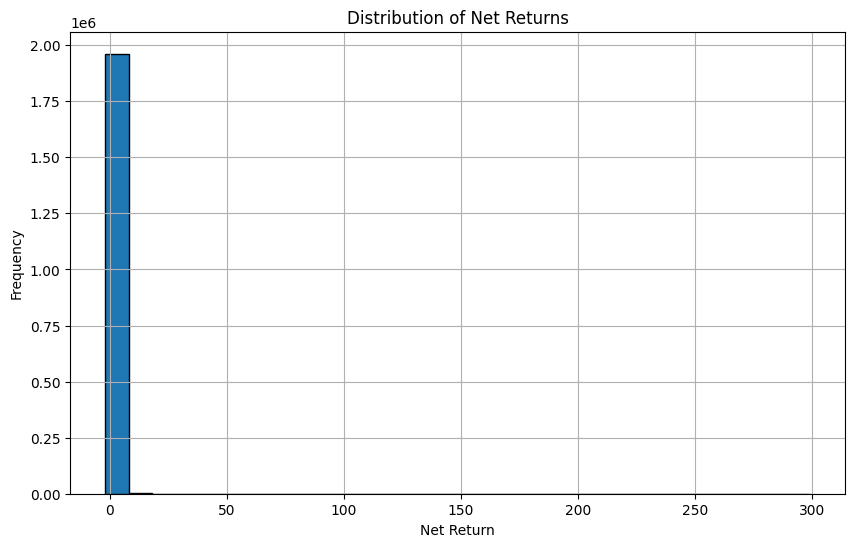

In [6]:
import matplotlib.pyplot as plt

# Assuming buys is your DataFrame and 'net_ret' is a column in it
plt.figure(figsize=(10, 6))
plt.hist(buys['net_ret'], bins=30, edgecolor='black')
plt.title('Distribution of Net Returns')
plt.xlabel('Net Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
buys['net_ret'].describe()

count    1.963980e+06
mean     1.750924e-02
std      5.835971e-01
min     -1.879200e+00
25%     -1.664798e-01
50%     -2.099307e-02
75%      1.232340e-01
max      2.989923e+02
Name: net_ret, dtype: float64

1th percentile: -0.7218873516461309
99th percentile: 1.3546003375367976


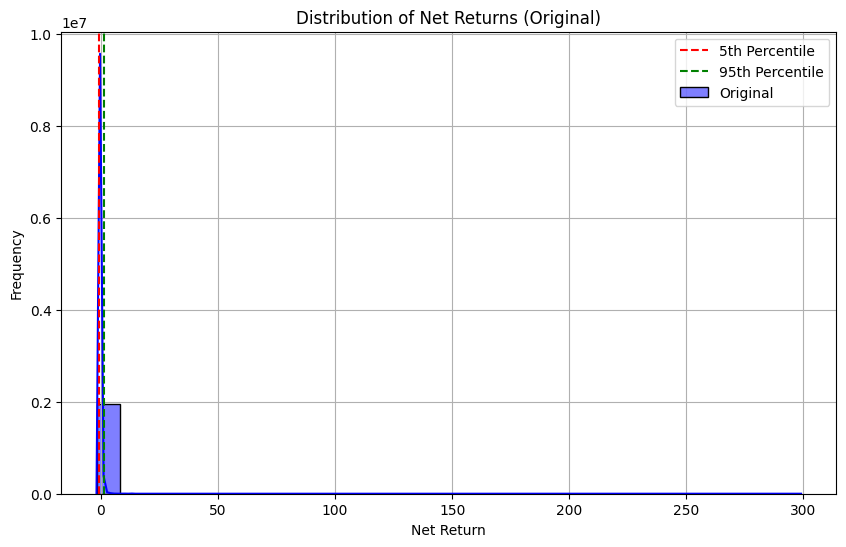

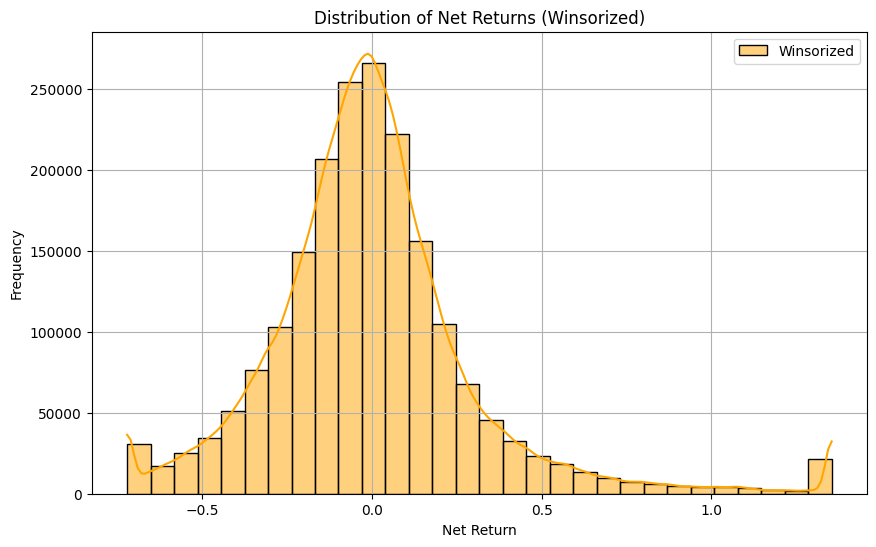

In [8]:
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
p1 = np.percentile(buys['net_ret'], 1)
p99 = np.percentile(buys['net_ret'], 99)

# Print the percentiles
print(f"1th percentile: {p1}")
print(f"99th percentile: {p99}")

# Apply Winsorization
buys['net_ret_winsorized'] = winsorize(buys['net_ret'], limits=[0.01, 0.01])

# Plot the histogram of the original 'net_ret'
plt.figure(figsize=(10, 6))
sns.histplot(buys['net_ret'], bins=30, kde=True, color="blue", label="Original")
plt.axvline(x=p1, color='r', linestyle='--', label='5th Percentile')
plt.axvline(x=p99, color='g', linestyle='--', label='95th Percentile')
plt.title('Distribution of Net Returns (Original)')
plt.xlabel('Net Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plot the histogram of the winsorized 'net_ret'
plt.figure(figsize=(10, 6))
sns.histplot(buys['net_ret_winsorized'], bins=30, kde=True, color="orange", label="Winsorized")
plt.title('Distribution of Net Returns (Winsorized)')
plt.xlabel('Net Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import statsmodels.api as sm
x = buys['year'].values
y = buys['net_ret_winsorized'].values

x = sm.add_constant(x)

# Perform the regression
model = sm.OLS(y, x).fit(cov_type='cluster', cov_kwds={'groups': buys['dcn'].values})

# Print the summary, which includes coefficients, standard errors, and other statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     573.9
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          8.31e-127
Time:                        22:39:45   Log-Likelihood:            -4.9344e+05
No. Observations:             1963980   AIC:                         9.869e+05
Df Residuals:                 1963978   BIC:                         9.869e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2775      0.346     23.910      0.0

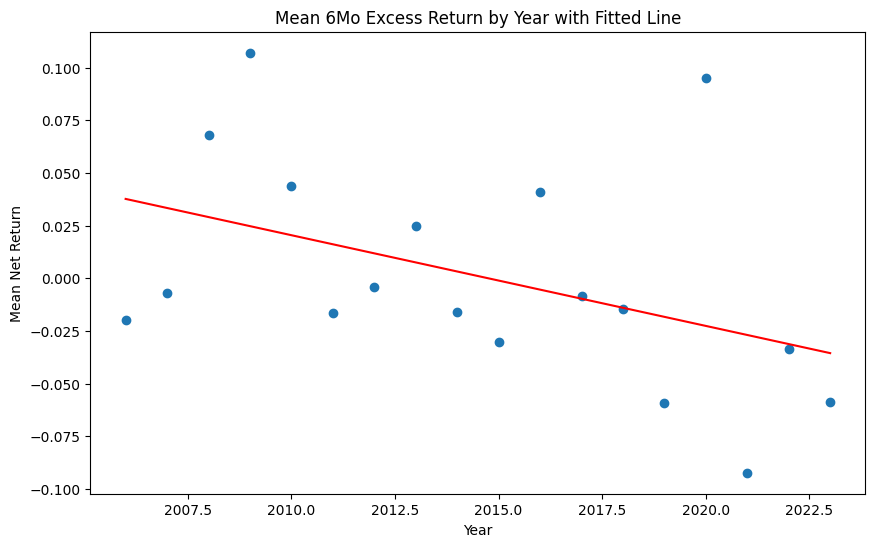

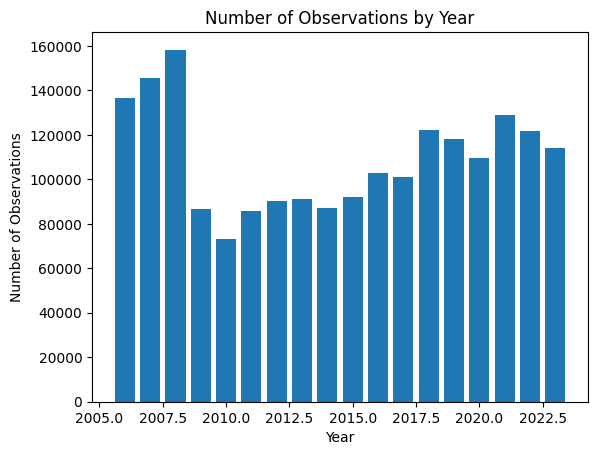

In [10]:
mean_net_ret_by_year = buys.groupby('year')['net_ret_winsorized'].mean().reset_index()

import numpy as np
x = mean_net_ret_by_year['year'].values
y = mean_net_ret_by_year['net_ret_winsorized'].values

coefficients = np.polyfit(x, y, deg=1)
poly_eq = np.poly1d(coefficients)
y_fit = poly_eq(x)
plt.figure(figsize=(10, 6))
plt.plot(mean_net_ret_by_year['year'], mean_net_ret_by_year['net_ret_winsorized'], marker='o', linestyle='', label='Data Points')
plt.plot(x, y_fit, color='red', linestyle='-', label='Fitted Line')
plt.title('Mean 6Mo Excess Return by Year with Fitted Line')
plt.xlabel('Year')
plt.ylabel('Mean Net Return')
plt.grid(False)
plt.show()

obs_count_by_year = buys['year'].value_counts().sort_index()
plt.bar(obs_count_by_year.index, obs_count_by_year.values)
plt.title('Number of Observations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.grid(False)